In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import scanpy as sc
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import progeny
import pandas as pd
import scipy.stats
import scanpy_helpers as sh

sc.set_figure_params(figsize=(4, 4))

In [3]:
adata = sc.read_h5ad("../../data/30_merge_adata/adata_scvi.h5ad")

In [4]:
adata_malignant_b = sc.read_h5ad(
    "../../data/40_cluster_analysis/adata_malignant_b_cells.h5ad"
)

In [5]:
artifact_dir = "../../data/70_downstream_analyses/pathway_analysis"

In [6]:
!mkdir -p {artifact_dir}

# Progeny

In [7]:
model = progeny.load_model(
    organism="Human",  # If working with mouse, set to Mouse
    top=1000,  # For sc we recommend ~1k target genes since there are dropouts
)

In [8]:
progeny.run(
    adata,
    model,
    center=True,  # Center gene expression by mean per cell
    num_perm=0,  # Simulate m random activities
    norm=True,  # Normalize by number of edges to correct for large regulons
    scale=True,  # Scale values per feature so that values can be compared across cells
)

7353 genes found


# Progeny of FOS+ cluster vs rest

In [9]:
adata_pw = progeny.extract(adata)

In [10]:
adata_pw.obs["cell_type"].unique()

['other', 'malignant B cell', 'healthy B cell', 'malignant B cell (dividing)']
Categories (4, object): ['healthy B cell', 'malignant B cell', 'malignant B cell (dividing)', 'other']

In [41]:
pb_pw = sh.pseudobulk.pseudobulk(
    adata_pw[adata_pw.obs["cell_type"].isin(["malignant B cell", "healthy B cell"]), :],
    aggr_fun=np.mean,
    groupby=["patient", "cell_type"],
)
pb_pw.obs["cell_type"] = pb_pw.obs["cell_type"].str.replace(" cell", "")

In [42]:
pb_pw._sanitize()

/data/scratch/sturm/conda/envs/2021-hairy-cell-leukemia-wolf-scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'patient' as categorical
/data/scratch/sturm/conda/envs/2021-hairy-cell-leukemia-wolf-scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'cell_type' as categorical


In [43]:
sc.tl.pca(pb_pw)
sc.tl.dendrogram(
    pb_pw, groupby=["patient", "cell_type"], use_rep="X_pca", linkage_method="average"
)

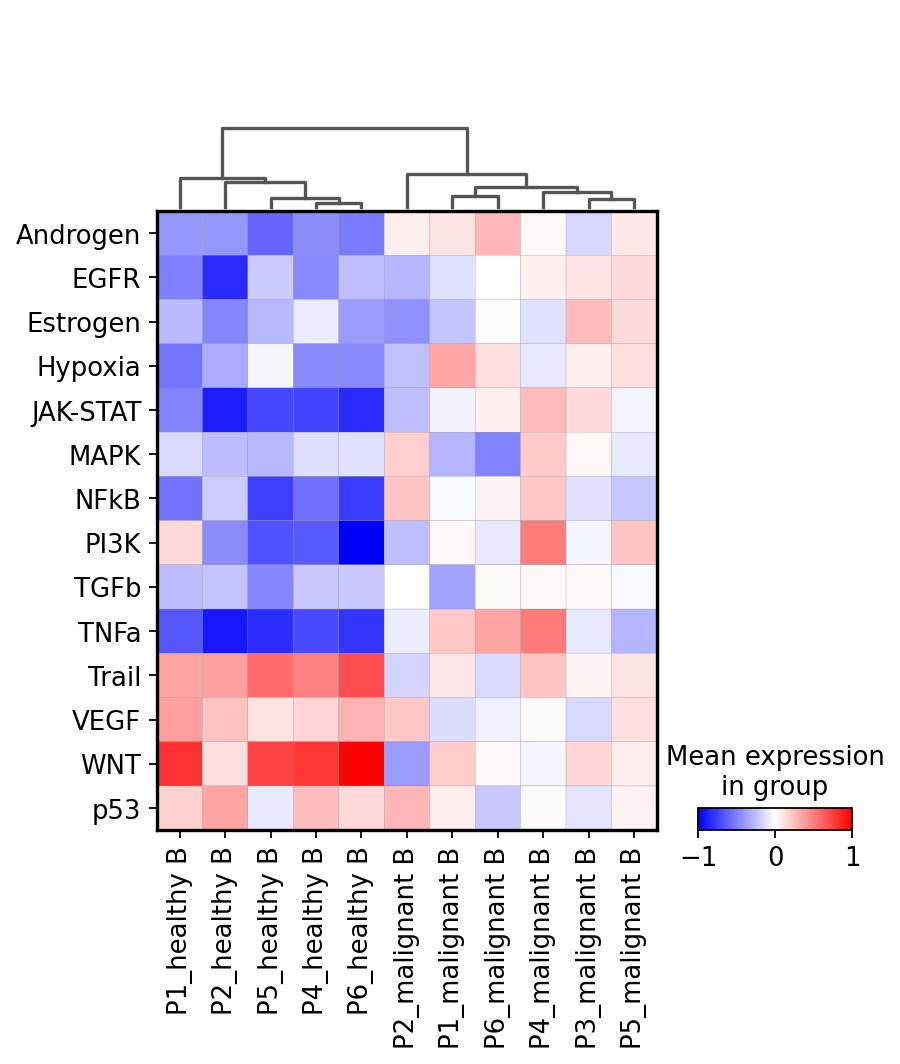

In [46]:
fig = sc.pl.matrixplot(
    pb_pw,
    var_names=pb_pw.var_names,
    groupby=["patient", "cell_type"],
    cmap="bwr",
    swap_axes=True,
    dendrogram=True,
    vmin=-1,
    vmax=1,
    return_fig=True,
)
fig.savefig(
    f"{artifact_dir}/progeny_healthy_vs_malignant_b_clustered_heatmap.pdf",
    bbox_inches="tight",
)

In [47]:
pb_pw.obs

,patient,cell_type,n_obs
0,P1,malignant B,420
1,P1,healthy B,21
2,P3,malignant B,13704
3,P2,malignant B,8053
4,P2,healthy B,149
5,P4,malignant B,3782
6,P4,healthy B,382
7,P6,malignant B,4186
8,P6,healthy B,74
9,P5,malignant B,5211


In [48]:
res = (
    sh.compare_groups.lm.test_lm(
        pb_pw,
        "~ C(cell_type, Treatment('healthy B')) + patient",
        groupby="cell_type",
        contrasts="Treatment('healthy B')",
    )
    .pipe(sh.util.fdr_correction)
    .sort_values("fdr")
)

  0%|          | 0/14 [00:00<?, ?it/s]

In [49]:
res

,coef,intercept,pvalue,variable,group,fdr
"C(cell_type, Treatment('healthy B'))[T.malignant B]",0.591804,-0.449323,0.000870,Androgen,malignant B,0.004590
"C(cell_type, Treatment('healthy B'))[T.malignant B]",0.409909,-0.517822,0.001874,EGFR,malignant B,0.004590
"C(cell_type, Treatment('healthy B'))[T.malignant B]",0.728258,-0.626451,0.001967,JAK-STAT,malignant B,0.004590
"C(cell_type, Treatment('healthy B'))[T.malignant B]",0.616750,-0.595747,0.001367,NFkB,malignant B,0.004590
"C(cell_type, Treatment('healthy B'))[T.malignant B]",0.924839,-0.682051,0.001783,TNFa,malignant B,0.004590
"C(cell_type, Treatment('healthy B'))[T.malignant B]",-0.725660,0.865182,0.001176,WNT,malignant B,0.004590
"C(cell_type, Treatment('healthy B'))[T.malignant B]",-0.477775,0.469004,0.011625,Trail,malignant B,0.023250
"C(cell_type, Treatment('healthy B'))[T.malignant B]",0.418090,-0.306280,0.045640,Hypoxia,malignant B,0.079869
"C(cell_type, Treatment('healthy B'))[T.malignant B]",0.713668,-0.264231,0.069160,PI3K,malignant B,0.100639
"C(cell_type, Treatment('healthy B'))[T.malignant B]",0.210704,-0.417727,0.071885,TGFb,malignant B,0.100639


In [51]:
ch = sh.compare_groups.pl.plot_lm_result_altair(res, p_cutoff=1)
ch.save(f"{artifact_dir}/progeny_healthy_vs_malignant_b_lm_heatmap.svg")
ch.display()

WARN Channel size should not be used with an unsorted discrete field.


alt.LayerChart(...)

In [19]:
sh.colors.plot_palette("patient")

alt.Chart(...)

In [52]:
# reorder for proper ordering of legend
pb_pw = pb_pw[
    pb_pw.obs.sort_values(["patient", "cell_type"]).index,
]

In [54]:
ch = sh.pairwise.plot_paired_fc(
    pb_pw,
    groupby="cell_type",
    paired_by="patient",
    metric="diff",
    var_names=res["variable"].tolist(),
    de_res_df=res,
    pvalue_col="fdr",
    var_col="variable",
)
ch.save(f"{artifact_dir}/progeny_healthy_vs_malignant_b_fold_change_bar_chart.svg")
ch.display()

alt.LayerChart(...)

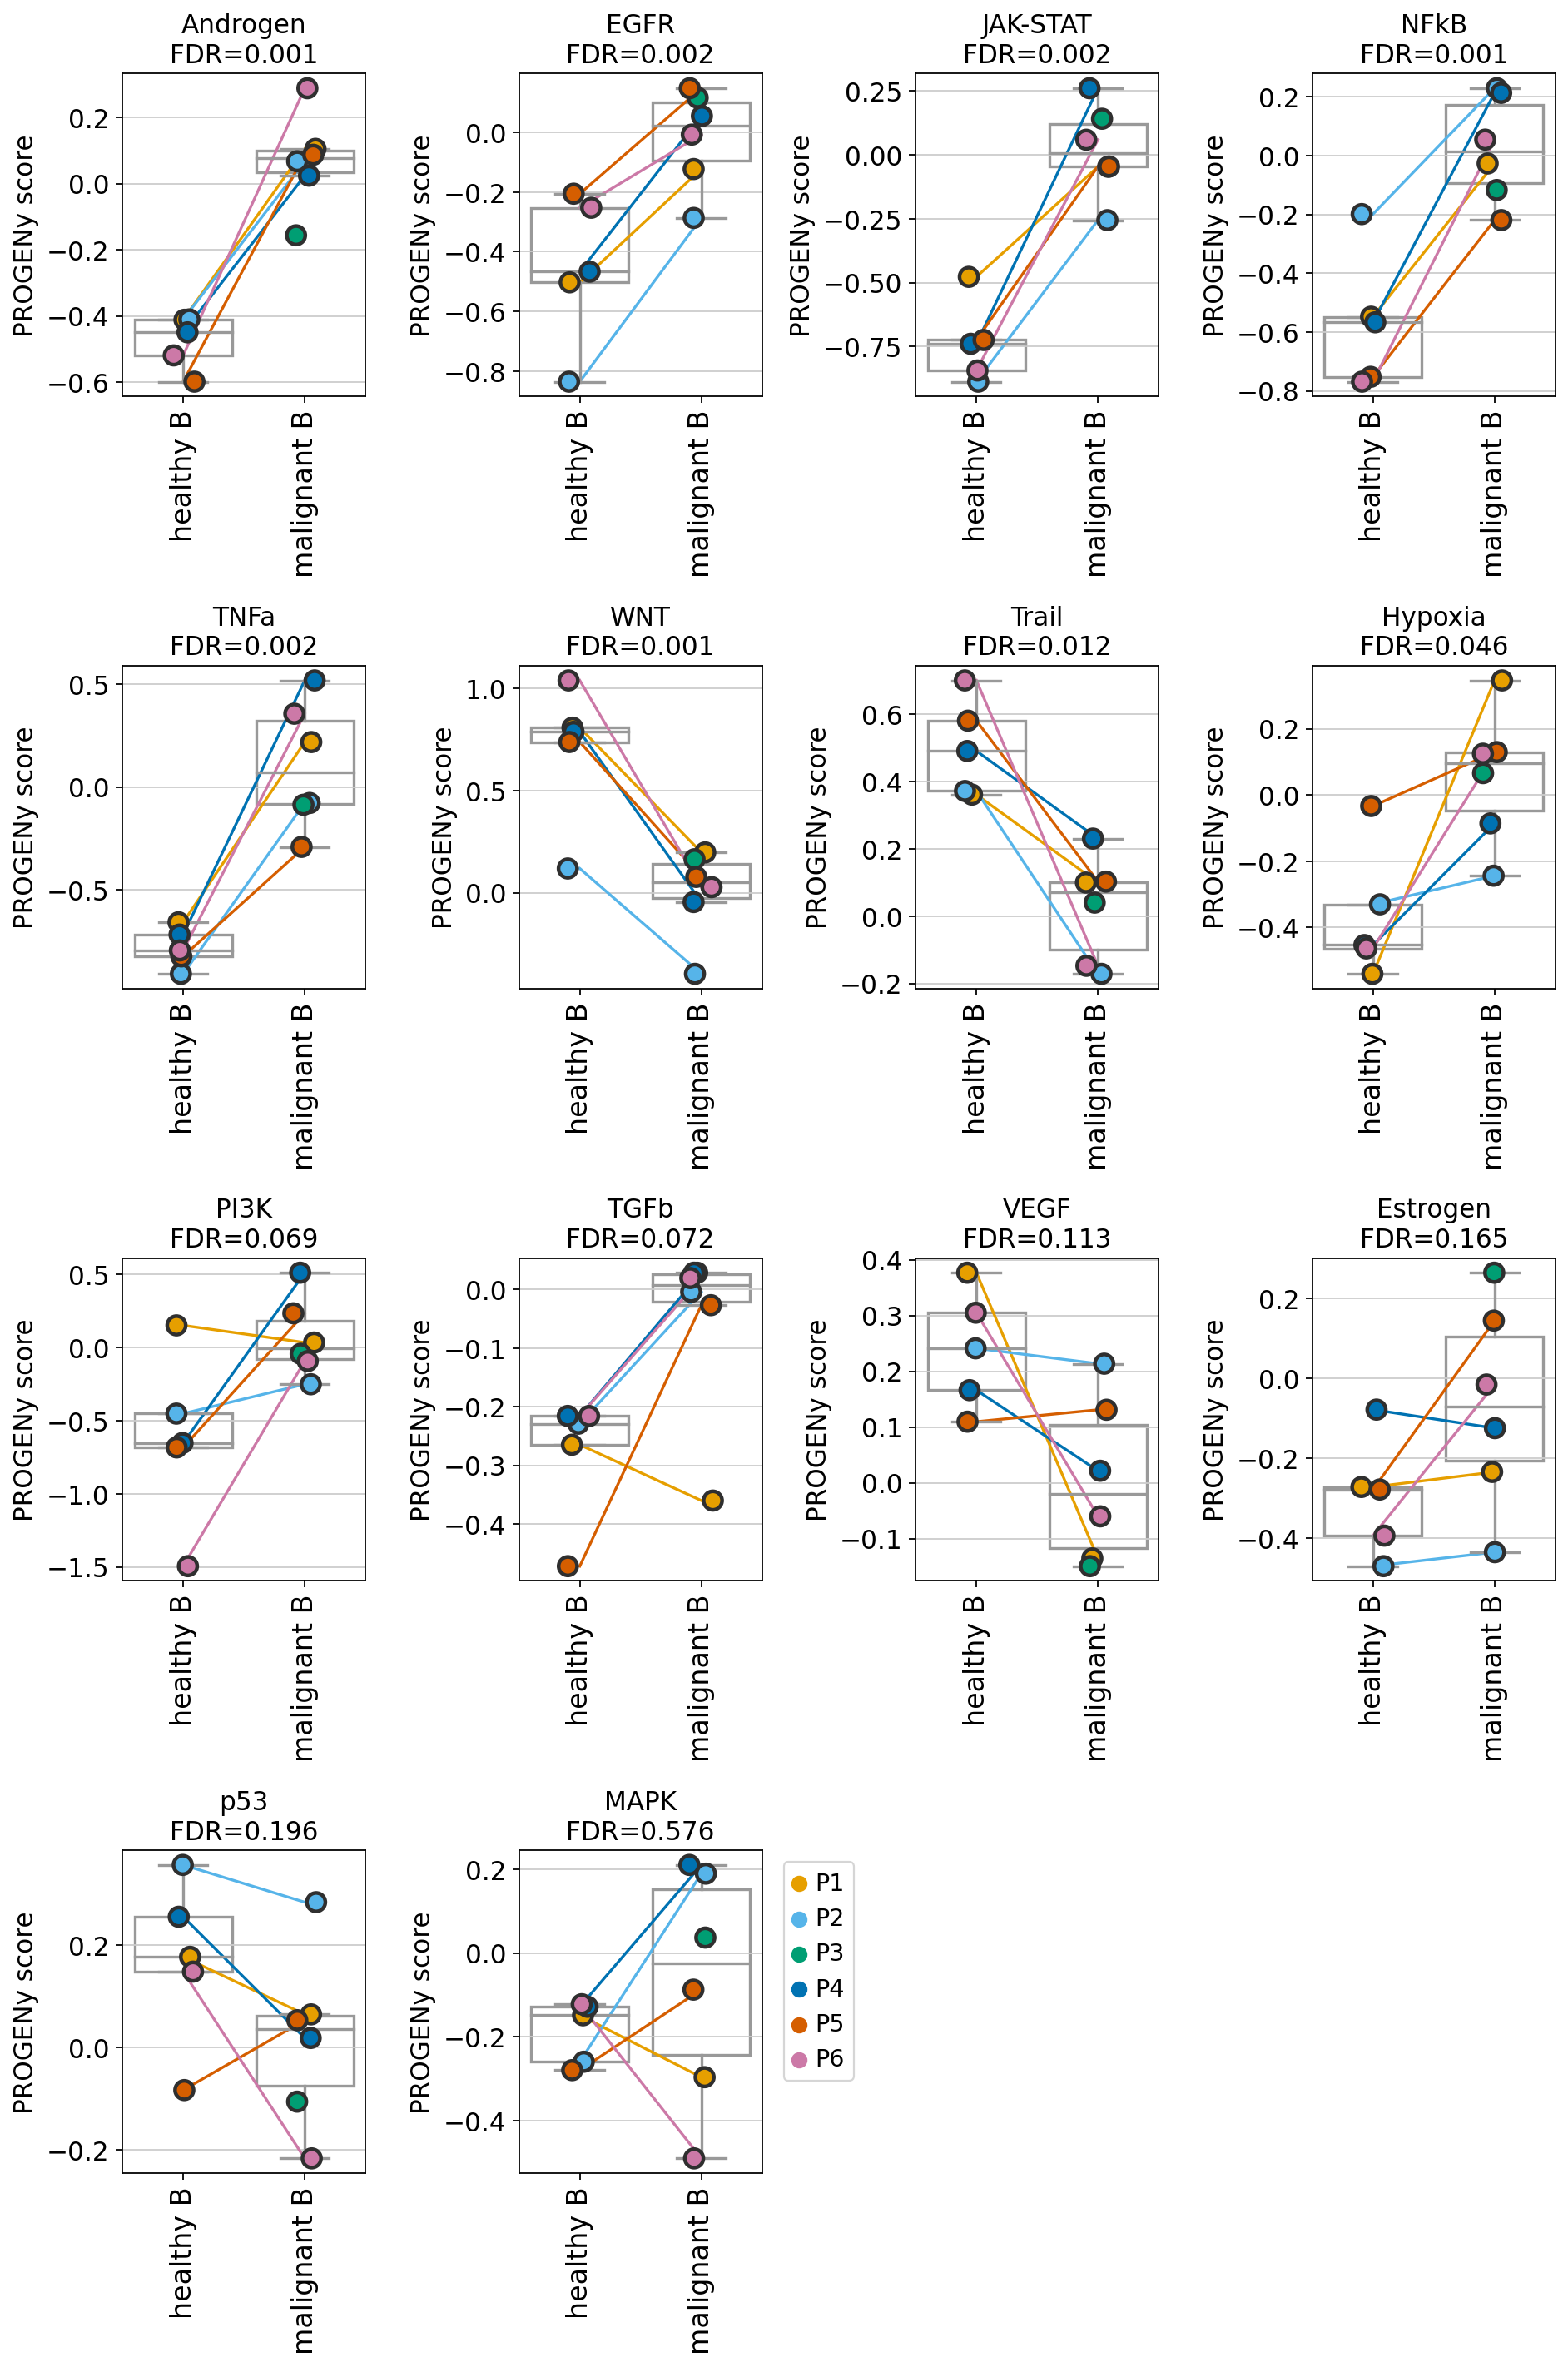

In [58]:
sns.set_palette(sns.color_palette(sh.colors.COLORS.patient.values()))
fig = sh.pairwise.plot_paired(
    pb_pw,
    groupby="cell_type",
    paired_by="patient",
    var_names=res["variable"].tolist(),
    ylabel="PROGENy score",
    pvalues=res["pvalue"].tolist(),
    pvalue_template="FDR={:.3f}",
    boxplot_kwargs={"color": "white"},
    panel_size=(3, 4.5),
    return_fig=True,
    rotate_x=90,
)
fig.savefig(
    f"{artifact_dir}/progeny_healthy_vs_malignant_b_paired_boxplot.pdf",
    bbox_inches="tight",
)

## SR vs LR (timepoint T0)

In [59]:
pb_pw_sr_lr = sh.pseudobulk.pseudobulk(
    adata_pw[
        (adata_pw.obs["timepoint"] == "T0")
        & (adata_pw.obs["cell_type"] == "malignant B cell"),
        :,
    ],
    groupby=["patient", "response"],
    aggr_fun=np.mean,
)

In [60]:
pb_pw_sr_lr.obs

,patient,response,n_obs
0,P2,short_term,3350
1,P4,long_term,3782
2,P6,long_term,4186
3,P3,short_term,1093
4,P5,long_term,5211


In [61]:
# reorder for proper ordering of legend
pb_pw_sr_lr = pb_pw_sr_lr[
    pb_pw_sr_lr.obs.sort_values(["patient", "response"]).index,
]

In [66]:
res = sh.compare_groups.lm.test_lm(
    pb_pw_sr_lr,
    "~ C(response, Treatment('long_term'))",
    groupby="response",
    contrasts="Treatment('long_term')",
).sort_values("pvalue")

  0%|          | 0/14 [00:00<?, ?it/s]

In [67]:
res

,coef,intercept,pvalue,variable,group
"C(response, Treatment('long_term'))[T.short_term]",-0.399556,0.065168,0.225479,EGFR,short_term
"C(response, Treatment('long_term'))[T.short_term]",-0.269620,0.056002,0.235897,Hypoxia,short_term
"C(response, Treatment('long_term'))[T.short_term]",-0.172260,0.019877,0.355022,WNT,short_term
"C(response, Treatment('long_term'))[T.short_term]",-0.375616,0.217738,0.360819,PI3K,short_term
"C(response, Treatment('long_term'))[T.short_term]",-0.180475,0.090831,0.426310,JAK-STAT,short_term
"C(response, Treatment('long_term'))[T.short_term]",-0.085086,0.132854,0.515310,Androgen,short_term
"C(response, Treatment('long_term'))[T.short_term]",0.115814,-0.048415,0.578221,p53,short_term
"C(response, Treatment('long_term'))[T.short_term]",-0.111786,0.061649,0.630775,Trail,short_term
"C(response, Treatment('long_term'))[T.short_term]",-0.170944,0.194207,0.631126,TNFa,short_term
"C(response, Treatment('long_term'))[T.short_term]",0.092431,0.015978,0.632523,NFkB,short_term


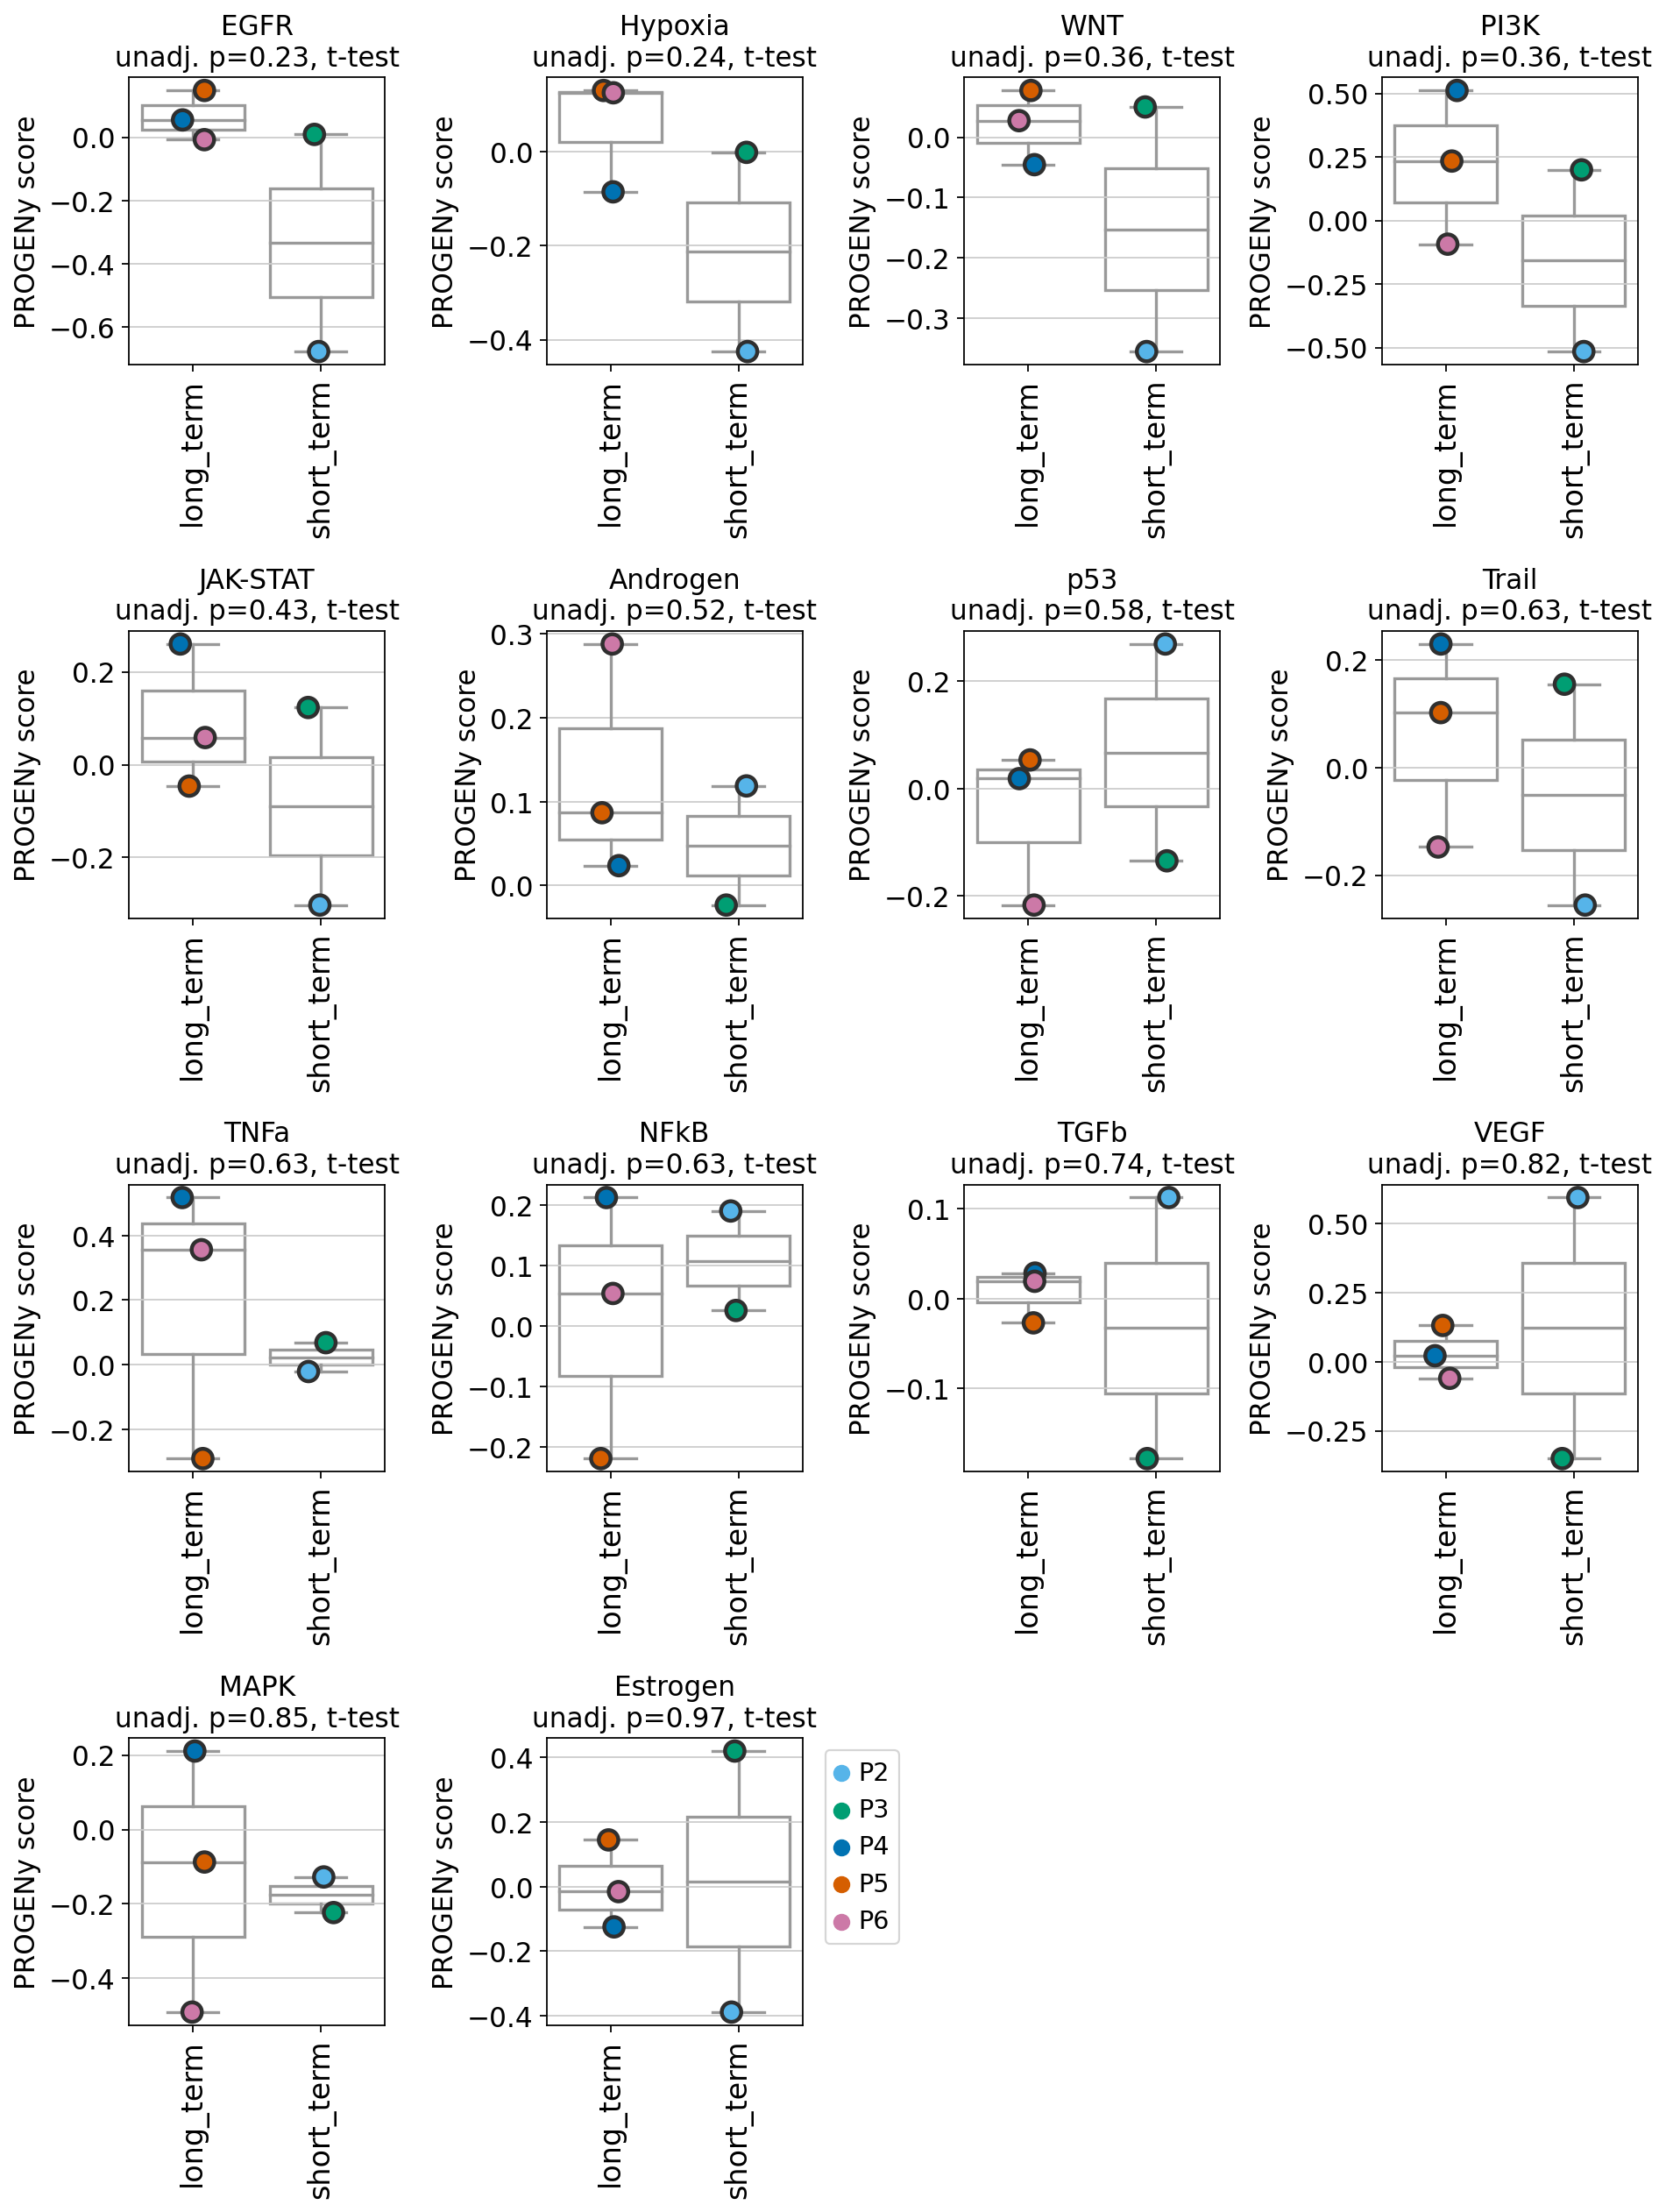

In [75]:
sns.set_palette(
    sns.color_palette(
        [sh.colors.COLORS.patient[p] for p in pb_pw_sr_lr.obs["patient"].unique()]
    )
)
fig = sh.pairwise.plot_paired(
    pb_pw_sr_lr,
    groupby="response",
    var_names=res["variable"].tolist(),
    ylabel="PROGENy score",
    pvalues=res["pvalue"].tolist(),
    boxplot_kwargs={"color": "white"},
    panel_size=(3, 4),
    rotate_x=90,
    hue="patient",
    return_fig=True,
)
fig.savefig(
    f"{artifact_dir}/progeny_long_term_vs_short_term_t0_paired_boxplot.pdf",
    bbox_inches="tight",
)

## malignant B vs Fos malignant B

In [70]:
progeny.run(
    adata_malignant_b,
    model,
    center=True,  # Center gene expression by mean per cell
    num_perm=0,  # Simulate m random activities
    norm=True,  # Normalize by number of edges to correct for large regulons
    scale=True,  # Scale values per feature so that values can be compared across cells
)

7353 genes found


In [71]:
adata_pw_malignant_b = progeny.extract(adata_malignant_b)

In [72]:
pb_pw_malignant_b = sh.pseudobulk.pseudobulk(
    adata_pw_malignant_b,
    aggr_fun=np.mean,
    groupby=["patient", "cell_phenotype"],
)

In [84]:
pb_pw_malignant_b.obs["cell_phenotype"] = pd.Categorical(
    pb_pw_malignant_b.obs["cell_phenotype"],
    categories=["malignant_b", "fos_malignant_b"],
)

In [85]:
sc.tl.pca(pb_pw_malignant_b)
sc.tl.dendrogram(
    pb_pw_malignant_b,
    groupby=["patient", "cell_phenotype"],
    use_rep="X_pca",
    linkage_method="average",
)

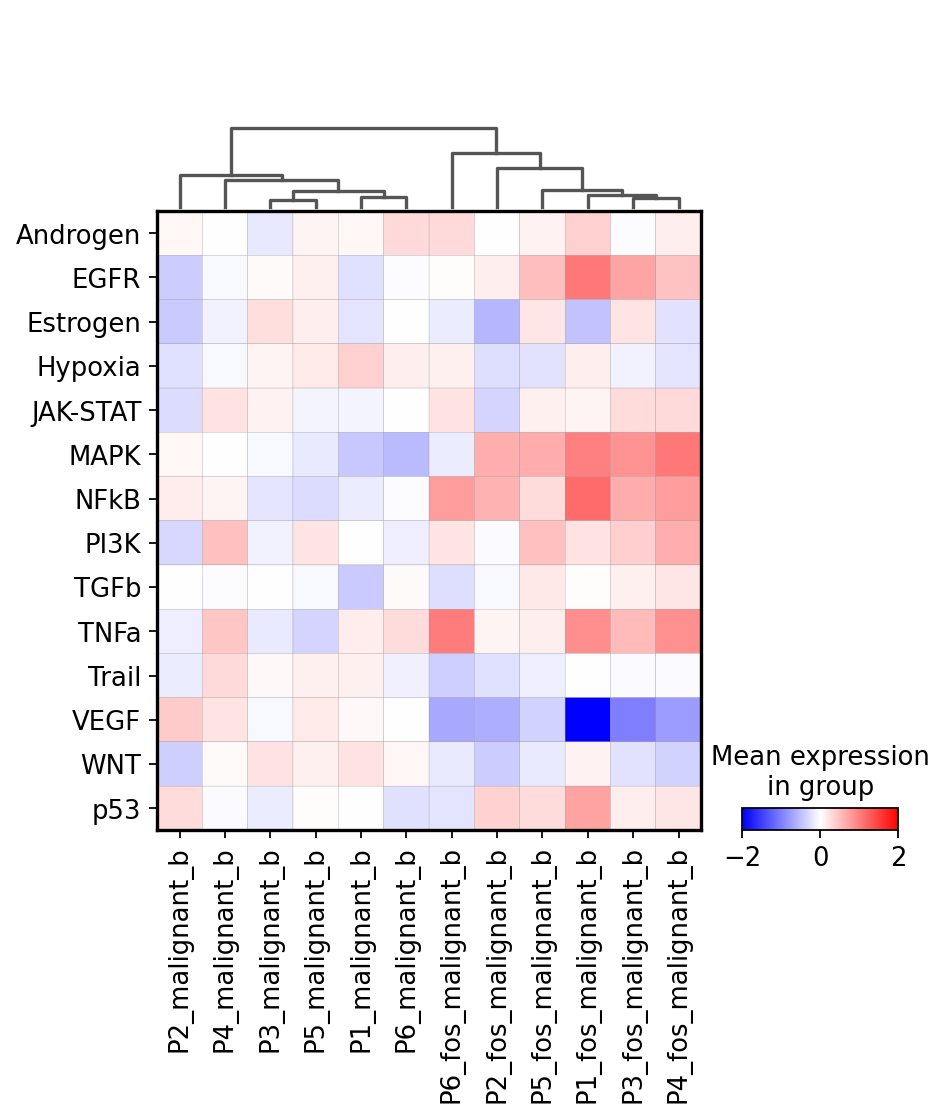

In [86]:
fig = sc.pl.matrixplot(
    pb_pw_malignant_b,
    var_names=pb_pw_malignant_b.var_names,
    groupby=["patient", "cell_phenotype"],
    cmap="bwr",
    swap_axes=True,
    dendrogram=True,
    vmin=-2,
    vmax=2,
    return_fig=True,
)
fig.savefig(
    f"{artifact_dir}/progeny_malignant_b_vs_fos_malignant_b_clustered_heatmap.pdf",
    bbox_inches="tight",
)

In [87]:
res = (
    sh.compare_groups.lm.test_lm(
        pb_pw_malignant_b,
        "~ C(cell_phenotype, Treatment('malignant_b')) + patient",
        groupby="cell_phenotype",
        contrasts="Treatment('malignant_b')",
    )
    .pipe(sh.util.fdr_correction)
    .sort_values("fdr")
)

  0%|          | 0/14 [00:00<?, ?it/s]

In [88]:
res

,coef,intercept,pvalue,variable,group,fdr
"C(cell_phenotype, Treatment('malignant_b'))[T.fos_malignant_b]",0.777787,0.114933,0.001421,NFkB,fos_malignant_b,0.007261
"C(cell_phenotype, Treatment('malignant_b'))[T.fos_malignant_b]",0.288169,-0.025610,0.001556,PI3K,fos_malignant_b,0.007261
"C(cell_phenotype, Treatment('malignant_b'))[T.fos_malignant_b]",0.548436,0.239627,0.001470,TNFa,fos_malignant_b,0.007261
"C(cell_phenotype, Treatment('malignant_b'))[T.fos_malignant_b]",0.856168,-0.146072,0.002335,MAPK,fos_malignant_b,0.008171
"C(cell_phenotype, Treatment('malignant_b'))[T.fos_malignant_b]",-0.190093,0.150263,0.006795,Trail,fos_malignant_b,0.015856
"C(cell_phenotype, Treatment('malignant_b'))[T.fos_malignant_b]",-1.052046,-0.488122,0.006077,VEGF,fos_malignant_b,0.015856
"C(cell_phenotype, Treatment('malignant_b'))[T.fos_malignant_b]",-0.245355,0.288203,0.014033,WNT,fos_malignant_b,0.028066
"C(cell_phenotype, Treatment('malignant_b'))[T.fos_malignant_b]",0.578705,0.112879,0.018330,EGFR,fos_malignant_b,0.032077
"C(cell_phenotype, Treatment('malignant_b'))[T.fos_malignant_b]",0.126763,-0.064043,0.034177,JAK-STAT,fos_malignant_b,0.053165
"C(cell_phenotype, Treatment('malignant_b'))[T.fos_malignant_b]",-0.162838,0.333875,0.038149,Hypoxia,fos_malignant_b,0.053409


In [89]:
ch = sh.compare_groups.pl.plot_lm_result_altair(res, p_cutoff=1)
ch.save(f"{artifact_dir}/progeny_malignant_b_vs_fos_malignant_b_lm_heatmap.svg")
ch.display()

WARN Channel size should not be used with an unsorted discrete field.


alt.LayerChart(...)

In [90]:
# reorder for proper ordering of legend
pb_pw_malignant_b = pb_pw_malignant_b[
    pb_pw_malignant_b.obs.sort_values(["patient", "cell_phenotype"]).index,
]
pb_pw

View of AnnData object with n_obs × n_vars = 11 × 14
    obs: 'patient', 'cell_type', 'n_obs'
    uns: 'pca', 'dendrogram_patient_cell_type'
    obsm: 'X_pca'
    varm: 'PCs'

In [92]:
ch = sh.pairwise.plot_paired_fc(
    pb_pw_malignant_b,
    groupby="cell_phenotype",
    paired_by="patient",
    metric="diff",
    var_names=res["variable"].tolist(),
    de_res_df=res,
    pvalue_col="fdr",
    var_col="variable",
)
ch.save(f"{artifact_dir}/progeny_malignant_b_vs_fos_malignant_b_fold_change_barchart.svg")
ch.display()

alt.LayerChart(...)

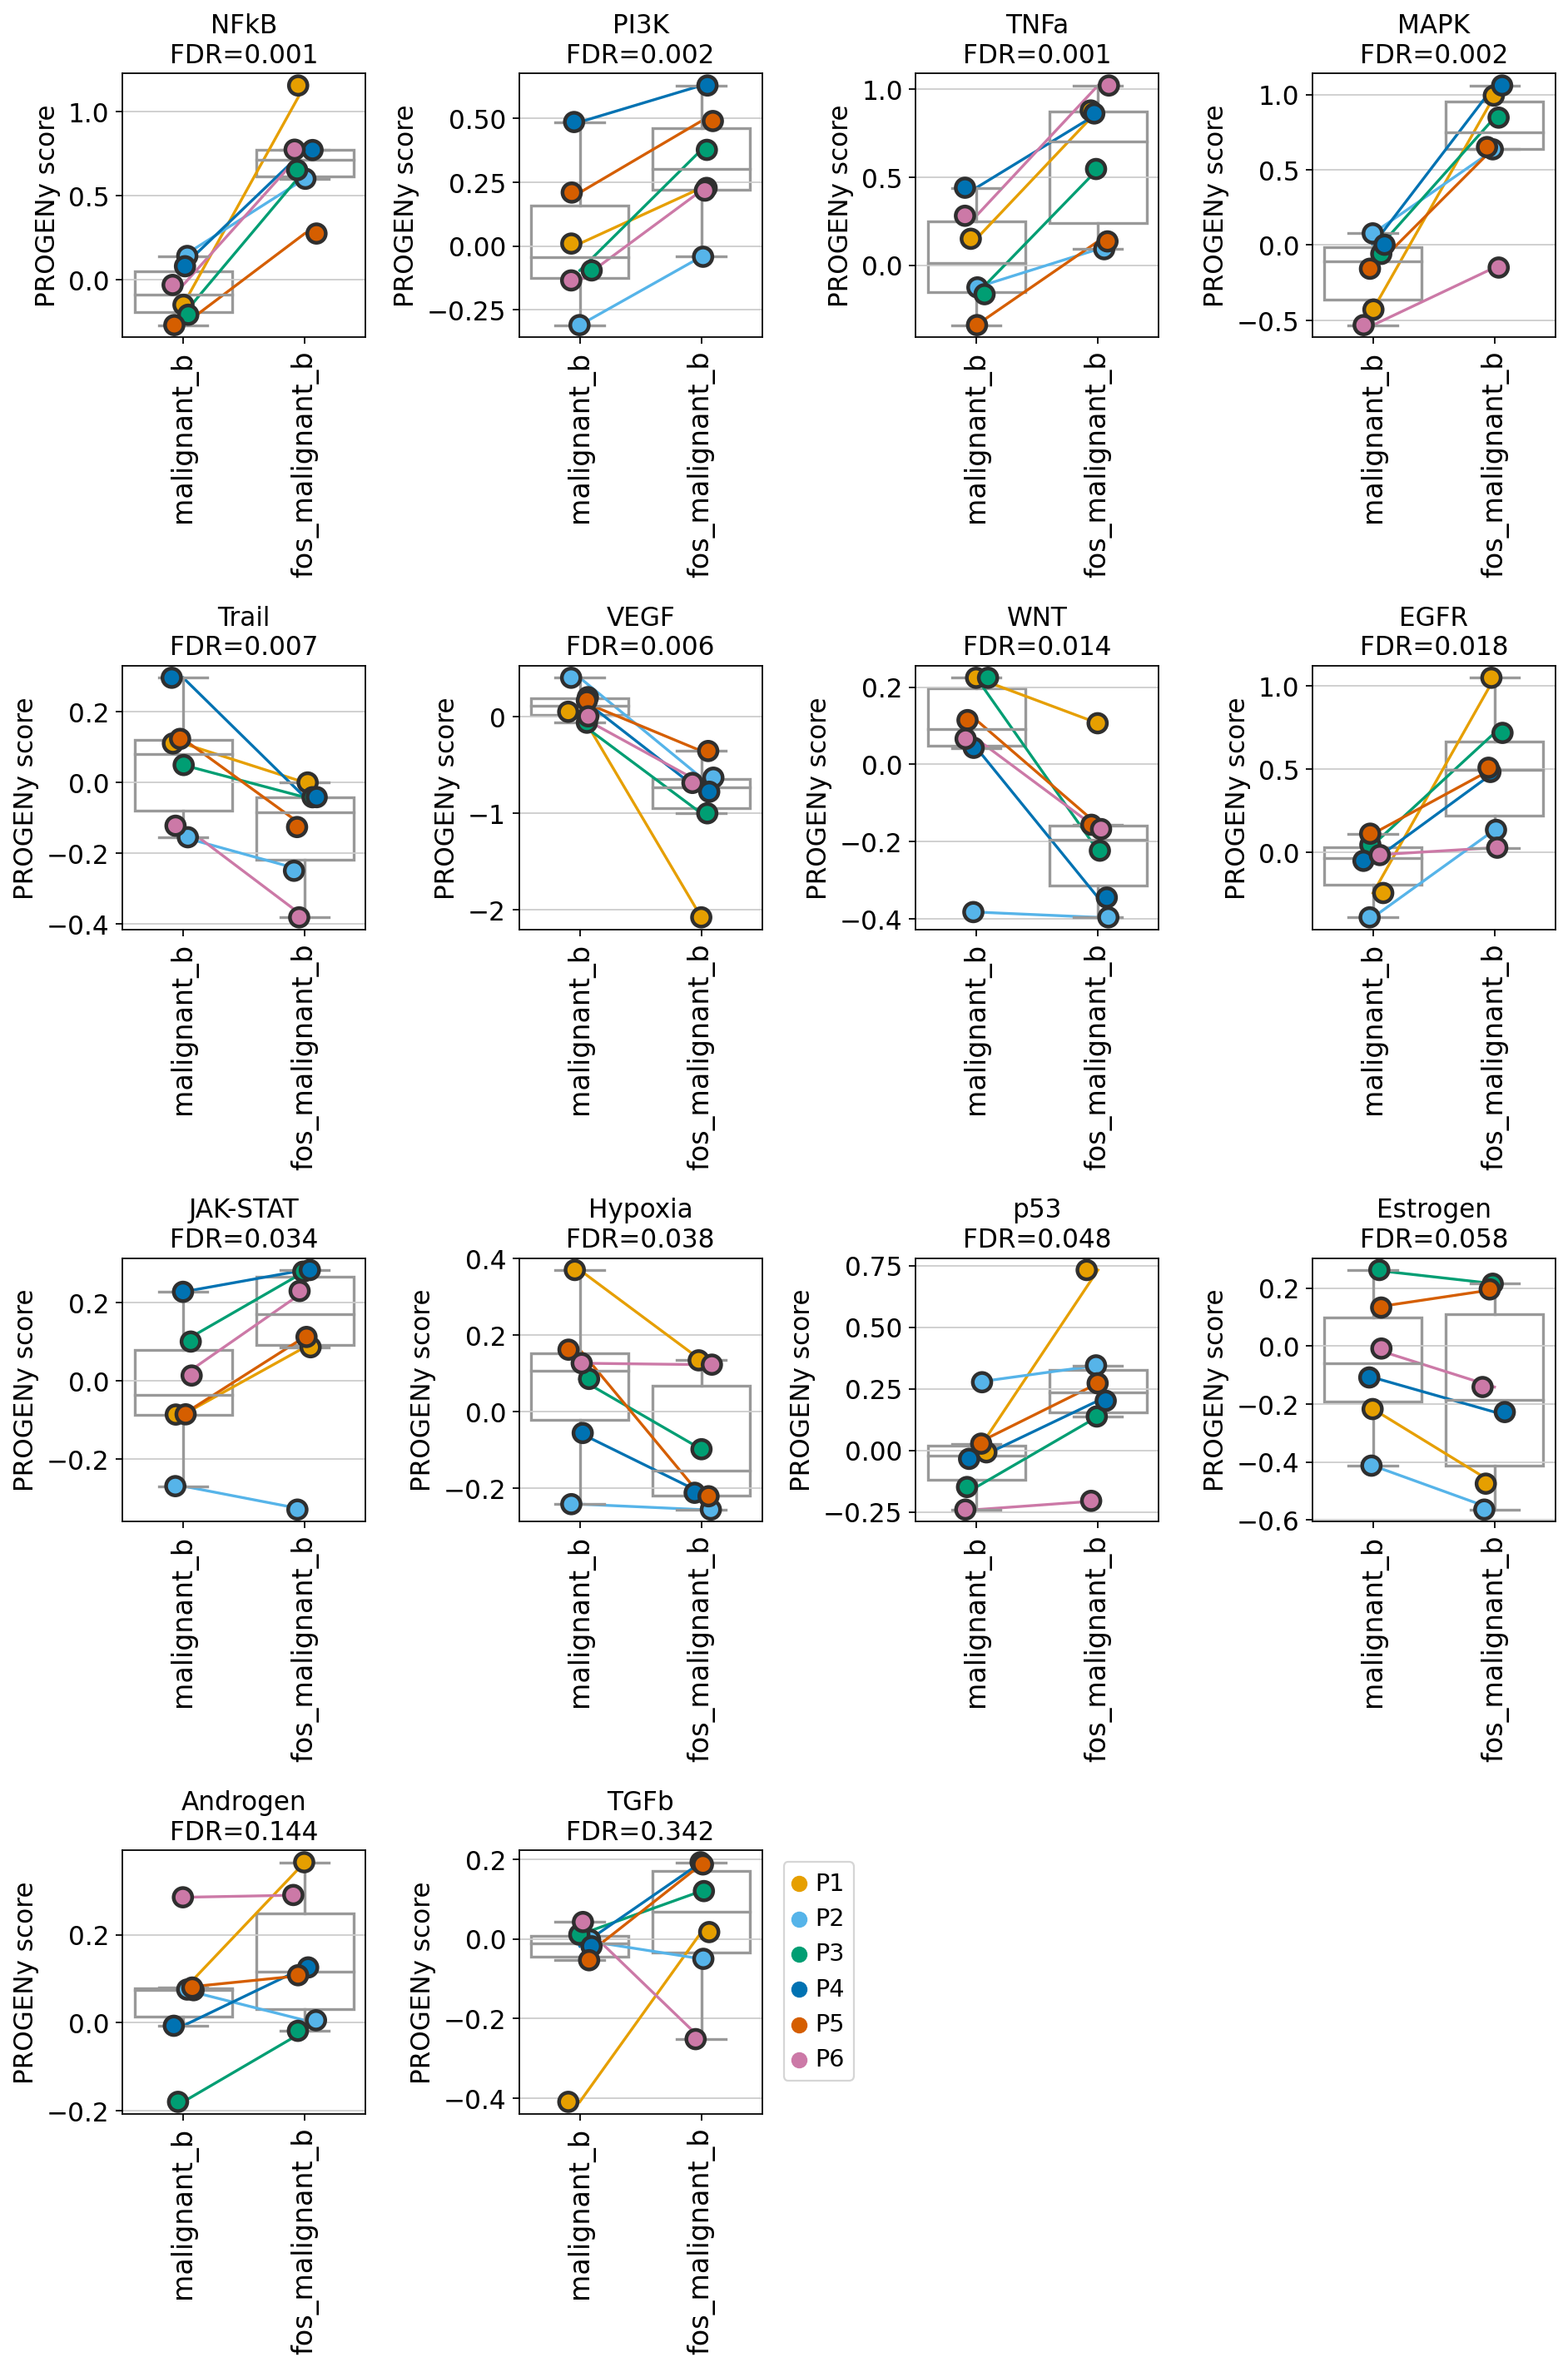

In [93]:
sns.set_palette(sns.color_palette(sh.colors.COLORS.patient.values()))
fig = sh.pairwise.plot_paired(
    pb_pw_malignant_b,
    groupby="cell_phenotype",
    paired_by="patient",
    var_names=res["variable"].tolist(),
    ylabel="PROGENy score",
    pvalues=res["pvalue"].tolist(),
    pvalue_template="FDR={:.3f}",
    boxplot_kwargs={"color": "white"},
    panel_size=(3, 4.5),
    rotate_x=90,
    return_fig=True
)
fig.savefig(f"{artifact_dir}/progeny_malignant_b_vs_fos_malignant_b_paired_boxplot.pdf", bbox_inches="tight")